In [1]:
!pip install transformers torch torchaudio datasets librosa

### **Notebook overview**

In this notebook, we perform mean pooling using Whisper embeddings

In [2]:
from datasets import load_dataset
import librosa
import io
import numpy as np
import torch

### **Dataset description**

10,000 audio samples representing 8 different emotions spoken by speakers of diverse age group. The dataset consists of audio samples spoken by both male and female speakers. The 8 emotion classes are "sad", "fear", "distress", "anger", "happy", "neutral" and "surprised". The audio format is raw bytes.

Link to dataset : [stapesai/ssi-speech-emotion-recognition-dataset](https://huggingface.co/datasets/stapesai/ssi-speech-emotion-recognition#dataset-card-for-ssi-speech-emotion-recognition---stapes-ai)

In [3]:
data = load_dataset("stapesai/ssi-speech-emotion-recognition")

### **Data Preprocessing steps**

1. Convert raw audio bytes into numerical format in the form of tensors.
2. Extract sample rate for each audio sample.
3. Map emotion classes to numerical labels.
4. Resample audio samples into uniform sample rate of 16000 Hz.
5. Pad or trucate the audio sample to maintain a uniform duration of 3 seconds.


In [4]:
# pad or truncate

def pad_or_truncate(waveform, max_length = 48000):

  """
   This function pads or truncates the audio sample such that each audio
   sample has the uniform length of 3 seconds.
  """
  
  num_samples = waveform.shape[0]
  waveform = torch.tensor(waveform).unsqueeze(0)

  if num_samples < max_length:  # Pad shorter audio
      pad = torch.zeros((1, max_length - num_samples))
      waveform = torch.cat((waveform, pad), dim=1)
  elif num_samples > max_length:  # Truncate longer audio
      waveform = waveform[:, :max_length]

  return waveform


# formatting the dataset

def format_data(df):

  """
    This function formats the dataset.
    
    -> Converts audio samples from raw audio bytes to numerical waveforms.
    -> Extracts the sample rate of samples.
    -> Maps string sentiment labels to numerical sentiment labels.
  """
    
  df["audio_bytes"] =  df["file_path"].apply(lambda x: x["bytes"])
  df["waveform"], df["sample_rate"] = zip(*df["audio_bytes"].apply(
        lambda x: librosa.load(io.BytesIO(x), sr=None)
    ))
  label_mapping = {
        "ANG": 0, "FEA": 1, "SAD": 2, "DIS": 3,
        "SUR": 4, "HAP": 5, "CAL": 6, "NEU": 7
    }
  df["label"] = df["emotion"].apply(lambda x: label_mapping[x])
  df = df[["waveform", "sample_rate", "label"]]

  return df

# feature engineering

def feature_engineering(data):

  """
    This functions defines additional features to the dataset.

    -> "Length" depicts the length of overall length of the waveform. (Should be 48000.
    Sampled at 16000 Hz and 3 seconds long).
  """
    
  data["length"] = data["waveform"].apply(lambda x: len(x[0]))
  return data

# resampling data
def resample_data(data):

  """
    This function resamples the audio sample to 16000 Hz.
  """
    
  data["waveform"] = data.apply(
    lambda row: librosa.resample(np.array(row["waveform"]), orig_sr=row["sample_rate"], target_sr=16000),
    axis=1
  )
  data["sample_rate"] = data["sample_rate"].apply(lambda x: 16000)
  data["waveform"] = data["waveform"].apply(pad_or_truncate)

  return data

# preprocessing data

def preprocess_dataset(df, set_):

  """
  This function applies the overall preprocessing pipeline to each audio sample.
  """
    
  data = df[set_].to_pandas()
  data = format_data(data)
  data = resample_data(data)
  data = feature_engineering(data)
  return data

In [5]:
data_train = preprocess_dataset(data, "train")
data_val = preprocess_dataset(data, "validation")

### **Extracting embedding vectors**

Here, I have chosen three speech models : Hubert base, Word2vec base and Whisper base to extract the embedding vector from the last hidden state. The ideas is to build a classification model on top of these embedding vectors to classify sentiments. The embedding vectors will have an indepth understanding of speakers traits, phonetics and accent.

**Model links:**

1. Hubert base - [Link](https://huggingface.co/facebook/hubert-base-ls960)
2. Word2vec base - [Link](https://huggingface.co/facebook/wav2vec2-base)
3. Whisper base - [Link](https://huggingface.co/openai/whisper-base)

This notebook will cover sentiment classification using Hubert and Wav2vec

In [6]:
from transformers import WhisperProcessor
from transformers import AutoModel

model_name = "openai/whisper-base"
model = AutoModel.from_pretrained(model_name)

feature_extractor = WhisperProcessor.from_pretrained("openai/whisper-base")

In [7]:
# Extracting sample feature vector for each model

whisper_features = feature_extractor(data_train["waveform"][0].squeeze(0), sampling_rate=16000, return_tensors="pt")

# Printing one sample feature vector for each model along with their shapes

print(f"Whisper feature :\n\n{whisper_features}\n\nShape : {whisper_features['input_features'].shape}")

Whisper feature :

{'input_features': tensor([[[ 0.1089,  0.3248,  0.4461,  ..., -0.9896, -0.9896, -0.9896],
         [ 0.2905,  0.3035,  0.2809,  ..., -0.9896, -0.9896, -0.9896],
         [ 0.1513,  0.1638,  0.4065,  ..., -0.9896, -0.9896, -0.9896],
         ...,
         [-0.6213, -0.5166, -0.5778,  ..., -0.9896, -0.9896, -0.9896],
         [-0.6704, -0.5887, -0.5690,  ..., -0.9896, -0.9896, -0.9896],
         [-0.5919, -0.5195, -0.5675,  ..., -0.9896, -0.9896, -0.9896]]])}

Shape : torch.Size([1, 80, 3000])


In [8]:
import pandas as pd

# Merging train and validation datasets

data_train["split"] = "train"
data_val["split"] = "validation"
data = pd.concat([data_train, data_val], ignore_index=True)

In [9]:
from sklearn.model_selection import train_test_split

data, _ = train_test_split(data, test_size=0.6, stratify=data['label'], random_state=42)

In [10]:
data["whisper_features"] = data["waveform"].apply(lambda x: feature_extractor(x.squeeze(0), sampling_rate=16000, return_tensors="pt")["input_features"])

In [13]:
# Extracting embeddings from Whisper model
 
def get_embeddings(feature, model):
  global count, device
  count += 1

  feature = feature.to(device)  
  with torch.no_grad():
      outputs = model.encoder(feature)

  embeddings = outputs.last_hidden_state

  if count == 1:
      print(f"\nWhisper embeddings shape : {embeddings.shape}\n")
 
  mean_embeddings = embeddings.mean(dim=1)

  del embeddings
    
  if count%500 == 0:
      print(f"Embeddings stored  : {count}/{len(data)}")

  return mean_embeddings

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
whisper_model = model.to(device)

torch.cuda.empty_cache()

count = 0
print("Extracting whisper embeddings :\n\n")
data["mean_whisper_embeddings"] = data["whisper_features"].apply(lambda x : get_embeddings(x, whisper_model))

Extracting whisper embeddings :



Whisper embeddings shape : torch.Size([1, 1500, 512])

Embeddings stored  : 500/4799
Embeddings stored  : 1000/4799
Embeddings stored  : 1500/4799
Embeddings stored  : 2000/4799
Embeddings stored  : 2500/4799
Embeddings stored  : 3000/4799
Embeddings stored  : 3500/4799
Embeddings stored  : 4000/4799
Embeddings stored  : 4500/4799


In [15]:
def min_max_scaling(x):

    """This function does min max scalling to the embedding vectors"""

    mean = x.mean(dim=1, keepdim=True) 
    std = x.std(dim=1, keepdim=True) 

    scaled_embeddings = (x - mean) / std

    return scaled_embeddings

In [16]:
data["scaled_mean_whisper_embeddings"] = data["mean_whisper_embeddings"].apply(min_max_scaling)

In [17]:
X = torch.stack(data['scaled_mean_whisper_embeddings'].tolist()).squeeze(1)

In [18]:
y = torch.tensor(data["label"].tolist())

In [19]:
from sklearn.model_selection import train_test_split


def train_test_splitter(X,y):

    """
    Given a set of traiable params 'X' and target values 'y', this function
    splits the input data into train and test sets.
    """

    X = X.cpu().numpy()
    y = y.numpy()
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)
    
    return X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor

In [20]:
from torch.utils.data import Dataset, DataLoader

# Preparing dataset for hubert and wav2vec embeddings and target labels

class EmbeddingsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X  
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def data_loader(X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor):

    """This function loads the dataset using pytorch DataLoader."""

    train_dataset = EmbeddingsDataset(X_train_tensor, y_train_tensor)
    val_dataset = EmbeddingsDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

    return train_loader, val_loader

In [21]:
def data_loader_pipeline(X, y):
    X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_splitter(X,y)
    train_loader, val_loader = data_loader(X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor)
    return train_loader, val_loader

In [22]:
whisper_train_loader, whisper_val_loader = data_loader_pipeline(X,y)

In [26]:
input_size = 512
num_classes = len(set(y))

In [27]:
import torch.nn as nn
import torch.optim as optim

class AudioClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(AudioClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 128) 
        self.fc3 = nn.Linear(128, num_classes) 
        self.dropout = nn.Dropout(0.3)  

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x) 
        return x

In [33]:
model = AudioClassifier(input_size, num_classes)

In [34]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001) 

In [35]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in whisper_train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(whisper_train_loader):.4f}")

Epoch [1/100], Loss: 1.9899
Epoch [2/100], Loss: 1.6490
Epoch [3/100], Loss: 1.4719
Epoch [4/100], Loss: 1.3492
Epoch [5/100], Loss: 1.2635
Epoch [6/100], Loss: 1.2068
Epoch [7/100], Loss: 1.1521
Epoch [8/100], Loss: 1.1319
Epoch [9/100], Loss: 1.1054
Epoch [10/100], Loss: 1.0705
Epoch [11/100], Loss: 1.0655
Epoch [12/100], Loss: 1.0425
Epoch [13/100], Loss: 1.0086
Epoch [14/100], Loss: 1.0127
Epoch [15/100], Loss: 1.0253
Epoch [16/100], Loss: 0.9981
Epoch [17/100], Loss: 0.9924
Epoch [18/100], Loss: 1.0008
Epoch [19/100], Loss: 0.9767
Epoch [20/100], Loss: 0.9640
Epoch [21/100], Loss: 0.9650
Epoch [22/100], Loss: 0.9601
Epoch [23/100], Loss: 0.9447
Epoch [24/100], Loss: 0.9380
Epoch [25/100], Loss: 0.9256
Epoch [26/100], Loss: 0.9266
Epoch [27/100], Loss: 0.9168
Epoch [28/100], Loss: 0.8978
Epoch [29/100], Loss: 0.9174
Epoch [30/100], Loss: 0.8944
Epoch [31/100], Loss: 0.9031
Epoch [32/100], Loss: 0.8926
Epoch [33/100], Loss: 0.8892
Epoch [34/100], Loss: 0.8908
Epoch [35/100], Loss: 0

In [36]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

model.eval()
y_true = [] 
y_pred = []
correct, total = 0, 0

with torch.no_grad():
    for X_batch, y_batch in whisper_val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)  # Get class with highest probability
        total += y_batch.size(0)
        y_true.extend(y_batch)
        y_pred.extend(predicted)
        correct += (predicted == y_batch).sum().item()

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Accuracy: 70.94%


In [37]:
y_pred_stacked = torch.stack(y_pred)
y_pred_numpy = y_pred_stacked.cpu().numpy()
y_test_stacked = torch.stack(y_true)
y_test_numpy = y_test_stacked.cpu().numpy()

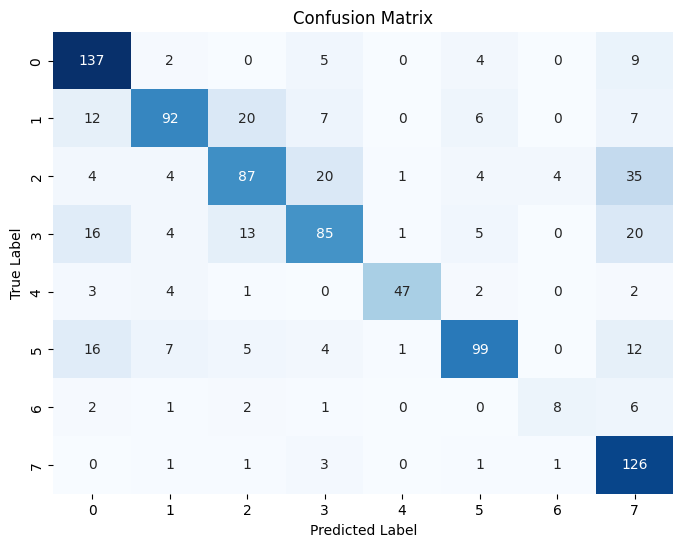

In [38]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test_numpy, y_pred_numpy)

# Step 3: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=np.unique(y_pred_numpy), yticklabels=np.unique(y_test_numpy))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [39]:
from sklearn.metrics import classification_report

report = classification_report(y_test_numpy, y_pred_numpy)
print(report)

              precision    recall  f1-score   support

           0       0.72      0.87      0.79       157
           1       0.80      0.64      0.71       144
           2       0.67      0.55      0.60       159
           3       0.68      0.59      0.63       144
           4       0.94      0.80      0.86        59
           5       0.82      0.69      0.75       144
           6       0.62      0.40      0.48        20
           7       0.58      0.95      0.72       133

    accuracy                           0.71       960
   macro avg       0.73      0.69      0.69       960
weighted avg       0.73      0.71      0.71       960

